# Identifiability

##### Keywords:  identifiability, MCMC, bayesian

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

We generate some test data from $N(0,1)$:

In [2]:
from scipy.stats import norm
data = norm.rvs(size=100)
data

array([  1.36915564e+00,   1.05529290e+00,  -4.60818168e-01,
         4.43641268e-01,   1.04113884e+00,   5.37649494e-01,
         7.60942560e-01,  -1.19804968e+00,   2.60566303e-01,
        -1.59689277e-01,   1.20547931e+00,   5.49728756e-01,
        -3.98610594e-01,   1.17620621e+00,  -1.02786937e-01,
         5.69037802e-01,  -6.01246985e-01,  -1.13331329e+00,
         8.54294530e-01,  -3.08324755e-01,   1.70618430e-01,
         4.51807215e-01,  -9.09119383e-02,  -1.78929328e-01,
         5.08269848e-01,  -1.24816874e+00,   4.75595913e-01,
         1.54785631e+00,  -4.71245561e-01,   1.62311337e+00,
        -3.41351283e-01,  -1.80469802e-01,   2.11632172e+00,
         8.41353133e-01,  -7.59104066e-01,  -1.55689174e+00,
        -2.41292745e-01,   2.24845053e-01,   3.91140426e-01,
        -6.85331082e-01,   5.79668372e-01,   8.36376400e-01,
        -2.54014208e-01,   1.75048511e+00,  -3.77872885e-01,
        -1.25172135e+00,  -2.17600397e-01,   3.15190627e-01,
         3.09352205e-01,

We fit this data using the following model:

$$
y \sim N(\mu, \sigma)\\
\mu = \alpha_1 + \alpha_2\\
\alpha_1 \sim Unif(-\infty, \infty)\\
\alpha_2 \sim Unif(-\infty, \infty)\\
\sigma \sim HalfCauchy(0,1)
$$

In [3]:
import pymc3 as pm

In our sampler, we have chosen `njobs=2` which allows us to run on multiple processes, generating two separate chains.

In [5]:
with pm.Model() as ni:
    sigma = pm.HalfCauchy("sigma", beta=1)
    alpha1=pm.Uniform('alpha1', lower=-10**6, upper=10**6)
    alpha2=pm.Uniform('alpha2', lower=-10**6, upper=10**6)
    mu = pm.Deterministic("mu", alpha1 + alpha2)
    y = pm.Normal("data", mu=mu, sd=sigma, observed=data)
    stepper=pm.Metropolis()
    traceni = pm.sample(100000, step=stepper, njobs=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha2]
>Metropolis: [alpha1]
>Metropolis: [sigma]
Sampling 2 chains: 100%|██████████| 201000/201000 [01:09<00:00, 2875.45draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


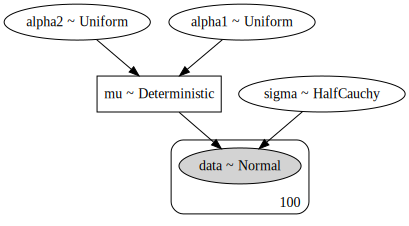

In [6]:
pm.model_to_graphviz(ni)

In [7]:
pm.summary(traceni)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.929859,0.067029,0.000488,0.798521,1.059213,21927.306462,1.000014
alpha1,0.965169,1.275430,0.125124,-1.363886,3.242092,3.084729,1.371864
alpha2,-0.829637,1.276056,0.125050,-3.128876,1.486237,3.073467,1.372306
mu,0.135532,0.091854,0.001345,-0.037689,0.322161,4918.178358,1.000050


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


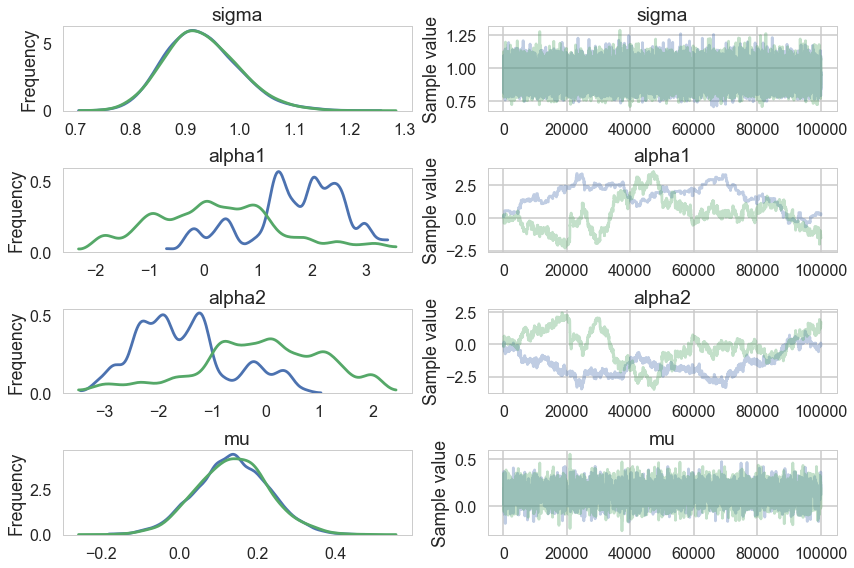

In [8]:
pm.traceplot(traceni);

Look at our traces for $\alpha_1$ and $\alpha_2$. These are bad, and worse, they look entirely different for two chains. Despite this, $\mu$ looks totally fine. Our trac

In [9]:
df=pm.trace_to_dataframe(traceni)
df.corr()

,sigma,alpha1,alpha2,mu
sigma,1.000000,0.001891,-0.002385,-0.006882
alpha1,0.001891,1.000000,-0.997408,0.029191
alpha2,-0.002385,-0.997408,1.000000,0.042806
mu,-0.006882,0.029191,0.042806,1.000000


Just like in our uncentered regression example, we have $\alpha_1$ and $\alpha_2$ sharing information: they are totally negatively correlated and unidentifiable. Indeed our intuition probably told us as much.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c706198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e706780>]], dtype=object)

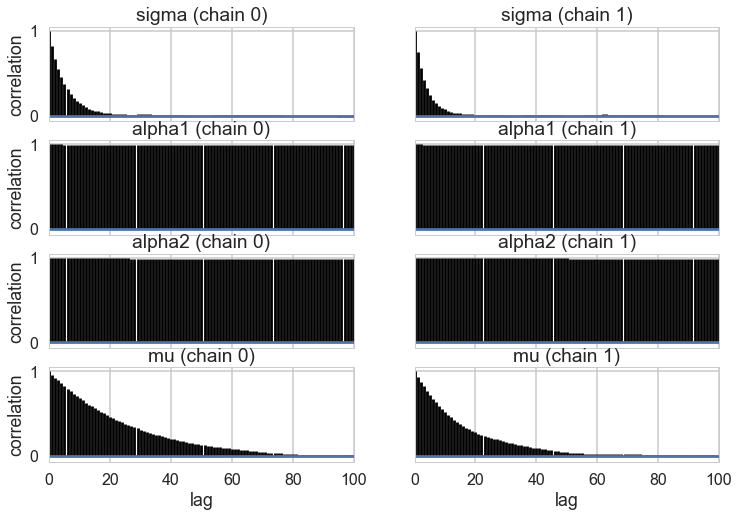

In [10]:
pm.autocorrplot(traceni)

A look at the effective number of samples using two chains tells us that we have only one effective sample for $\alpha_1$ and $\alpha_2$.

In [11]:
pm.effective_n(traceni)

{'alpha1': 3.0847290976843218,
 'alpha2': 3.0734670584705572,
 'mu': 4918.1783580295532,
 'sigma': 21927.306461639713}

The Gelman-Rubin statistic is awful for them. No convergence.

In [12]:
pm.gelman_rubin(traceni)

{'alpha1': 1.3718637421441382,
 'alpha2': 1.3723057686966671,
 'mu': 1.0000502933374407,
 'sigma': 1.0000144819583978}

Its going to be hard to break this unidentifiability. We try by forcing $\alpha_2$ to be negative in our prior

In [13]:
with pm.Model() as ni2:
    sigma = pm.HalfCauchy("sigma", beta=1)
    alpha1=pm.Normal('alpha1', mu=5, sd=1)
    alpha2=pm.Normal('alpha2', mu=-5, sd=1)
    mu = pm.Deterministic("mu", alpha1 + alpha2)
    y = pm.Normal("data", mu=mu, sd=sigma, observed=data)
    #stepper=pm.Metropolis()
    #traceni2 = pm.sample(100000, step=stepper, njobs=2)
    traceni2 = pm.sample(100000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha2, alpha1, sigma]
Sampling 2 chains: 100%|██████████| 201000/201000 [08:29<00:00, 394.59draws/s]


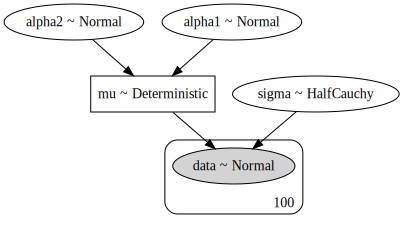

In [19]:
pm.model_to_graphviz(ni2)

Notice we are using the built in NUTS sampler. It takes longer but explores the distributions far better. This is directly related to our priors imposing regions. I could not even run the previous sampler in any reasonable time in NUTS.

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


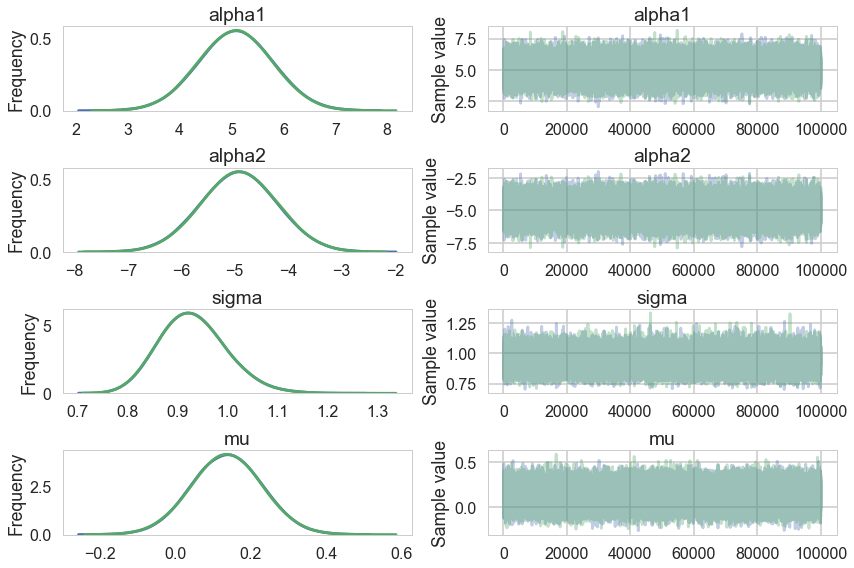

In [14]:
pm.traceplot(traceni2);

Our extremely strong priors have helped us do a much better job.

In [15]:
pm.summary(traceni2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha1,5.066310,0.708625,0.002569,3.678977,6.456753,77586.667382,1.000020
alpha2,-4.931296,0.708567,0.002562,-6.333776,-3.554861,77570.663271,1.000019
sigma,0.930199,0.066613,0.000198,0.805719,1.064302,96892.104502,0.999996
mu,0.135013,0.093098,0.000204,-0.045187,0.319260,195950.078927,0.999996


Our effective sample size is still poor and our traces still look dodgy, but things are better. 

In [16]:
pm.effective_n(traceni2)

{'alpha1': 77586.667381948821,
 'alpha2': 77570.663270675213,
 'mu': 195950.07892697665,
 'sigma': 96892.104501958092}

In [17]:
pm.gelman_rubin(traceni2)

{'alpha1': 1.0000203740430271,
 'alpha2': 1.000018798766553,
 'mu': 0.99999646960401545,
 'sigma': 0.99999594999714658}

..and this shows in our Gelman-Rubin statistics as well...

In [18]:
pm.trace_to_dataframe(traceni2).corr()

,alpha1,alpha2,sigma,mu
alpha1,1.000000,-0.991369,-0.003822,0.066316
alpha2,-0.991369,1.000000,0.003936,0.065067
sigma,-0.003822,0.003936,1.000000,0.000868
mu,0.066316,0.065067,0.000868,1.000000


..but our unidentifiability is still high when we look at the correlation. This reflects the fundamental un-identifiability and sharing of information in our model since $\mu = \alpha_1 +\alpha_2$: all the priors do is artificially peg one of the parameters. And once one is pegged the other is too because of the symmetry.